<a href="https://colab.research.google.com/github/jeshwanth-A/aiml_defi/blob/main/Aiml_Defi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Starting Crypto Sentiment Forecaster...

📦 Installing packages (this may take 2-3 minutes on first run)...
✅ Packages installed successfully!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📁 Save folder: /content/drive/MyDrive/crypto_project

📊 STEP 1: DATA PROCESSING
✅ Loading processed data from disk...
   Loaded 30 rows

✅ Dataset ready: 30 rows
✅ Created 20 sequences of length 10
   Train: 16 samples | Test: 4 samples

🌳 STEP 2: RANDOM FOREST BASELINE
✅ Random Forest MAE: 0.3548

🔥 STEP 3: PYTORCH LSTM
✅ Loaded PyTorch model from disk
✅ PyTorch LSTM MAE: 0.1894

🧠 STEP 4: TENSORFLOW LSTM
🔄 Loading TensorFlow model from disk...
✅ Loaded TensorFlow model
✅ TensorFlow LSTM MAE: 0.2089

🤖 STEP 5: LLM FINETUNING (LoRA)


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loading finetuned LLM...
✅ Loaded finetuned LLM

📈 STEP 6: GENERATING VISUALIZATIONS
✅ Saved visualization to: /content/drive/MyDrive/crypto_project/forecast_viz.png


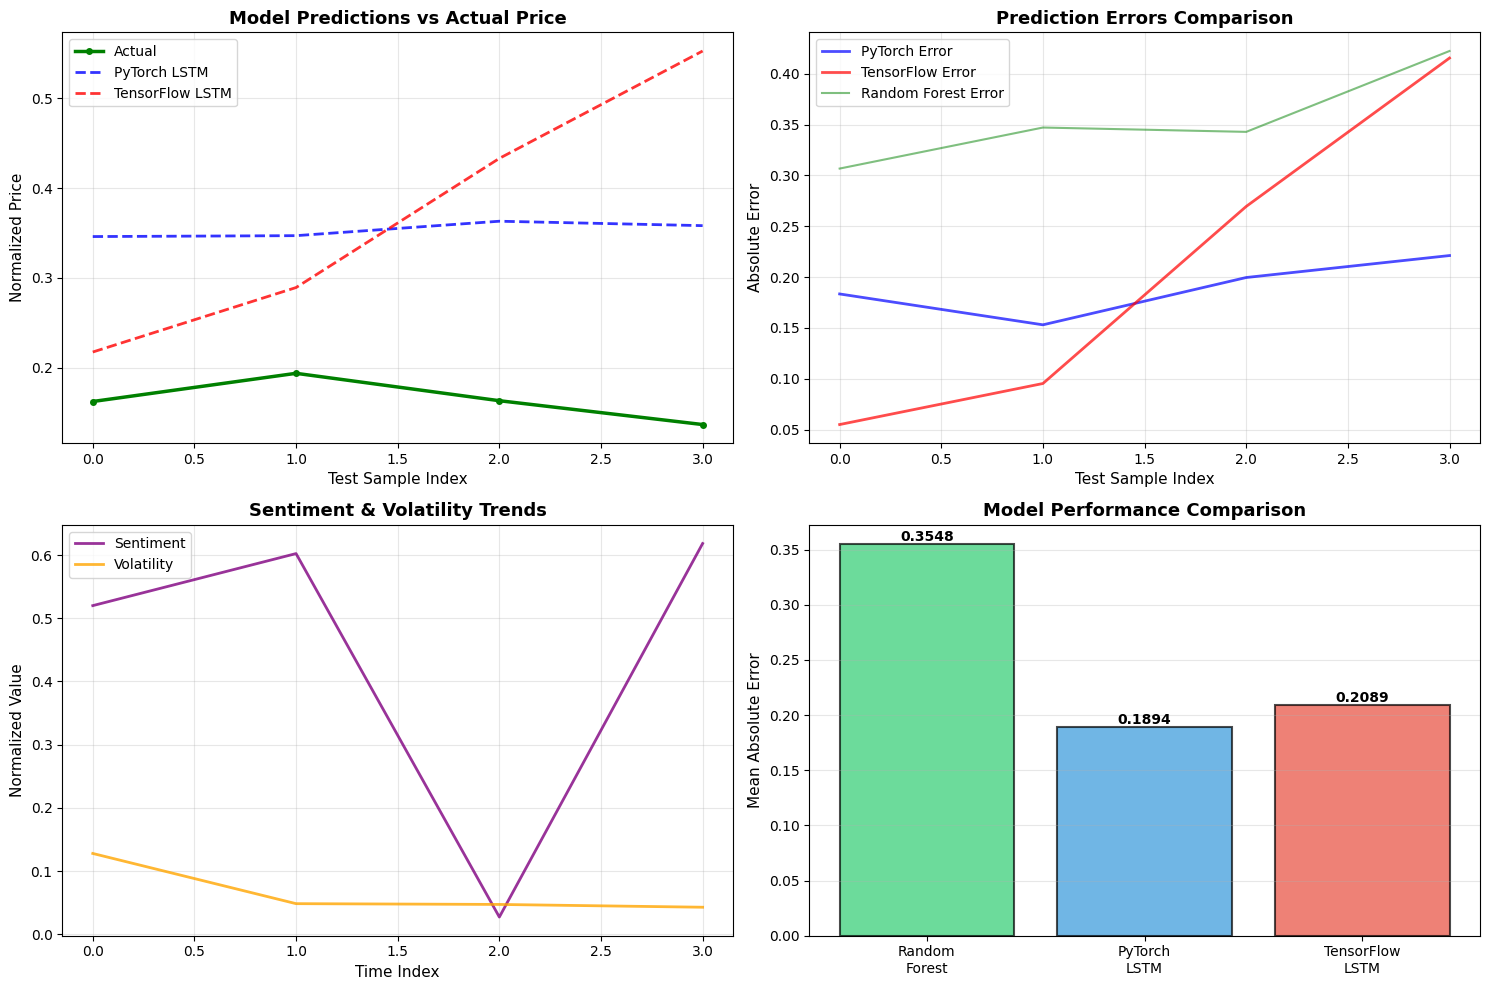


🎉 PROJECT COMPLETED SUCCESSFULLY!

📁 All files saved to: /content/drive/MyDrive/crypto_project

📊 Model Performance (Lower is Better):
   • Random Forest MAE:    0.3548
   • PyTorch LSTM MAE:     0.1894
   • TensorFlow LSTM MAE:  0.2089

🏆 Best Model: PyTorch LSTM (MAE: 0.1894)

💾 Saved Files:
   • Processed Data:  /content/drive/MyDrive/crypto_project/processed_data.csv
   • PyTorch Model:   /content/drive/MyDrive/crypto_project/model_pt.pth
   • TensorFlow Model: /content/drive/MyDrive/crypto_project/model_tf.h5
   • Finetuned LLM:   /content/drive/MyDrive/crypto_project/finetuned_llm
   • Visualization:   /content/drive/MyDrive/crypto_project/forecast_viz.png

✅ Run this code again - it will load from disk in ~30 seconds!

🏁 Script execution completed!


In [5]:
# ============================================================================
# CRYPTO SENTIMENT FORECASTER - COMPLETE CODE FOR GOOGLE COLAB
# ============================================================================
# Copy this entire code into a single Colab cell and run!
# First run: ~10 minutes (trains everything)
# Subsequent runs: ~30 seconds (loads from disk)
# ============================================================================

# Fix for notebook widget metadata error (MUST BE FIRST!)
import os
os.environ['JUPYTER_WIDGETS_ENABLED'] = 'false'
import warnings
warnings.filterwarnings('ignore')

print("🚀 Starting Crypto Sentiment Forecaster...")
print("=" * 60)

# ============================================================================
# STEP 0: Install Required Packages
# ============================================================================
print("\n📦 Installing packages (this may take 2-3 minutes on first run)...")

!pip install -q numpy pandas torch torchvision torchaudio
!pip install -q tensorflow
!pip install -q scikit-learn matplotlib
!pip install -q transformers peft datasets accelerate
!pip install -q huggingface-hub

print("✅ Packages installed successfully!")

# ============================================================================
# STEP 1: Import Libraries
# ============================================================================
import urllib.request
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import Dataset
from google.colab import drive
drive.mount('/content/drive')

# ============================================================================
# STEP 2: Setup Paths
# ============================================================================
save_folder = '/content/drive/MyDrive/crypto_project'
os.makedirs(save_folder, exist_ok=True)

pt_model_path = os.path.join(save_folder, 'model_pt.pth')
tf_model_path = os.path.join(save_folder, 'model_tf.h5')
llm_path = os.path.join(save_folder, 'finetuned_llm')
data_path = os.path.join(save_folder, 'processed_data.csv')

print(f"\n📁 Save folder: {save_folder}")

# ============================================================================
# STEP 3: Data Fetching Functions
# ============================================================================
def fetch_and_parse(token_id='uniswap', days=30):
    """Fetch crypto price data from CoinGecko API"""
    url = f"https://api.coingecko.com/api/v3/coins/{token_id}/market_chart?vs_currency=usd&days={days}&interval=daily"
    try:
        print(f"   Fetching {days} days of {token_id} data from CoinGecko...")
        with urllib.request.urlopen(url) as response:
            data = response.read().decode("utf-8")
            json_data = json.loads(data)

        required_keys = ['prices', 'total_volumes']
        for key in required_keys:
            if key not in json_data:
                print(f"   ⚠️ Warning: {key} is missing from API response")
                return None

        prices = json_data.get('prices', [])
        volumes = json_data.get('total_volumes', [])

        if len(prices) == 0 or len(volumes) == 0:
            print("   ⚠️ No data received from API")
            return None

        df = pd.DataFrame(prices, columns=['timestamp', 'price'])
        df['volume'] = [v[1] for v in volumes]
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

        print(f"   ✅ Fetched {len(df)} data points")
        return df

    except Exception as e:
        print(f"   ❌ Exception fetching data: {e}")
        return None

def add_sentiment(df):
    """Add mock sentiment data (replace with real API in production)"""
    np.random.seed(42)
    df['sentiment'] = np.random.uniform(-1, 1, size=len(df))
    return df

def create_sequences(data, seq_len=10):
    """Create sequences for time series prediction"""
    seq_len = min(seq_len, len(data) - 1)
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data.iloc[i:i+seq_len].values)
        y.append(data.iloc[i+seq_len]['price'])
    return np.array(X), np.array(y)

# ============================================================================
# STEP 4: PyTorch LSTM Model
# ============================================================================
class PricePredictor(nn.Module):
    """PyTorch LSTM model for price prediction"""
    def __init__(self, input_size=5, hidden_size=50, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# ============================================================================
# STEP 5: Data Processing
# ============================================================================
print("\n" + "=" * 60)
print("📊 STEP 1: DATA PROCESSING")
print("=" * 60)

if os.path.exists(data_path):
    print("✅ Loading processed data from disk...")
    df = pd.read_csv(data_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    print(f"   Loaded {len(df)} rows")
else:
    print("🔄 Fetching and processing fresh data...")
    df = fetch_and_parse(token_id='uniswap', days=30)

    if df is not None:
        # Clean data
        df = df.dropna()

        # Add sentiment
        df = add_sentiment(df)
        print("   ✅ Added sentiment features")

        # Calculate volatility using NumPy
        prices_np = df['price'].values
        window_size = min(5, len(prices_np))

        if len(prices_np) >= window_size:
            volatility = np.std(
                np.lib.stride_tricks.sliding_window_view(prices_np, window_size),
                axis=1
            )
            df['volatility'] = np.pad(volatility, (window_size-1, 0), mode='edge')
        else:
            df['volatility'] = 0

        print("   ✅ Calculated volatility")

        # Scale features
        scaler = MinMaxScaler()
        df[['price', 'volume', 'sentiment', 'volatility']] = scaler.fit_transform(
            df[['price', 'volume', 'sentiment', 'volatility']]
        )
        print("   ✅ Scaled features")

        # Create lag features
        df['price_lag1'] = df['price'].shift(1)
        df = df.dropna()

        # Save processed data
        df.to_csv(data_path, index=False)
        print(f"   ✅ Saved {len(df)} processed rows")
    else:
        print("   ❌ Failed to fetch data. Exiting.")
        df = None

# ============================================================================
# STEP 6: Model Training Pipeline
# ============================================================================
if df is not None and len(df) > 0:
    print(f"\n✅ Dataset ready: {len(df)} rows")

    # Create sequences
    features = df[['price', 'volume', 'sentiment', 'volatility', 'price_lag1']]
    seq_length = min(10, len(features) // 2)
    X, y = create_sequences(features, seq_len=seq_length)

    if len(X) == 0:
        print("❌ Not enough data to create sequences. Need more historical data.")
    else:
        print(f"✅ Created {len(X)} sequences of length {seq_length}")

        # Split data
        split = max(1, int(0.8 * len(X)))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        print(f"   Train: {len(X_train)} samples | Test: {len(X_test)} samples")

        # ====================================================================
        # MODEL 1: Random Forest Baseline
        # ====================================================================
        print("\n" + "=" * 60)
        print("🌳 STEP 2: RANDOM FOREST BASELINE")
        print("=" * 60)

        if len(X_train) > 0:
            rf = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=10)
            rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
            rf_preds = rf.predict(X_test.reshape(X_test.shape[0], -1))
            rf_mae = mean_absolute_error(y_test, rf_preds)
            print(f"✅ Random Forest MAE: {rf_mae:.4f}")

        # ====================================================================
        # MODEL 2: PyTorch LSTM
        # ====================================================================
        print("\n" + "=" * 60)
        print("🔥 STEP 3: PYTORCH LSTM")
        print("=" * 60)

        model_pt = PricePredictor(input_size=X_train.shape[2])

        if os.path.exists(pt_model_path):
            model_pt.load_state_dict(torch.load(pt_model_path))
            print("✅ Loaded PyTorch model from disk")
        else:
            print("🔄 Training PyTorch LSTM (50 epochs)...")
            optimizer = torch.optim.Adam(model_pt.parameters(), lr=0.001)
            criterion = nn.MSELoss()
            X_train_pt = torch.tensor(X_train, dtype=torch.float32)
            y_train_pt = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

            for epoch in range(50):
                model_pt.train()
                outputs = model_pt(X_train_pt)
                loss = criterion(outputs, y_train_pt)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (epoch + 1) % 10 == 0:
                    print(f"   Epoch {epoch + 1}/50 - Loss: {loss.item():.4f}")

            torch.save(model_pt.state_dict(), pt_model_path)
            print("✅ Saved PyTorch model")

        # Evaluate PyTorch model
        model_pt.eval()
        with torch.no_grad():
            X_test_pt = torch.tensor(X_test, dtype=torch.float32)
            preds_pt = model_pt(X_test_pt).numpy()

        pt_mae = mean_absolute_error(y_test, preds_pt)
        print(f"✅ PyTorch LSTM MAE: {pt_mae:.4f}")

        # ====================================================================
        # MODEL 3: TensorFlow LSTM
        # ====================================================================
        print("\n" + "=" * 60)
        print("🧠 STEP 4: TENSORFLOW LSTM")
        print("=" * 60)

        if os.path.exists(tf_model_path):
            print("🔄 Loading TensorFlow model from disk...")
            try:
                model_tf = tf.keras.models.load_model(
                    tf_model_path,
                    custom_objects={'mse': tf.keras.losses.MeanSquaredError()}
                )
                print("✅ Loaded TensorFlow model")
            except Exception as e:
                print(f"⚠️ Error loading model: {e}")
                print("   Deleting and retraining...")
                os.remove(tf_model_path)
                model_tf = None
        else:
            model_tf = None

        if model_tf is None:
            print("🔄 Training TensorFlow LSTM (50 epochs)...")
            model_tf = Sequential([
                LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
                Dense(1)
            ])
            model_tf.compile(
                optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError()
            )

            history = model_tf.fit(
                X_train, y_train,
                epochs=50,
                batch_size=max(1, len(X_train)//10),
                verbose=0
            )

            model_tf.save(tf_model_path)
            print("✅ Saved TensorFlow model")

        preds_tf = model_tf.predict(X_test, verbose=0)
        tf_mae = mean_absolute_error(y_test, preds_tf)
        print(f"✅ TensorFlow LSTM MAE: {tf_mae:.4f}")

        # ====================================================================
        # MODEL 4: LLM Finetuning with LoRA
        # ====================================================================
        print("\n" + "=" * 60)
        print("🤖 STEP 5: LLM FINETUNING (LoRA)")
        print("=" * 60)

        # Create training data for explanation model
        explanation_data = {
            'text': [
                "The prediction was close to actual value, showing good model performance.",
                "Large prediction error indicates model needs improvement.",
                "Price increased but prediction was lower, missing upward trend.",
                "Sentiment was positive and price rose as expected."
            ],
            'label': [1, 0, 0, 1]
        }
        dataset = Dataset.from_dict(explanation_data)

        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

        def preprocess(examples):
            return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

        dataset = dataset.map(preprocess, batched=True)
        dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

        if os.path.exists(os.path.join(llm_path, 'adapter_config.json')):
            print("✅ Loading finetuned LLM...")
            base_model = AutoModelForSequenceClassification.from_pretrained(
                "distilbert-base-uncased", num_labels=2
            )
            model_llm = PeftModel.from_pretrained(base_model, llm_path)
            print("✅ Loaded finetuned LLM")
        else:
            print("🔄 Finetuning LLM with LoRA (3 epochs)...")
            lora_config = LoraConfig(
                r=8,
                lora_alpha=32,
                target_modules=["q_lin", "v_lin"],
                lora_dropout=0.1,
                bias="none",
                task_type="SEQ_CLS"
            )
            base_model = AutoModelForSequenceClassification.from_pretrained(
                "distilbert-base-uncased", num_labels=2
            )
            model_llm = get_peft_model(base_model, lora_config)

            training_args = TrainingArguments(
                output_dir="./results",
                num_train_epochs=3,
                per_device_train_batch_size=2,
                save_strategy="epoch",
                logging_steps=10,
                report_to="none"
            )
            trainer = Trainer(
                model=model_llm,
                args=training_args,
                train_dataset=dataset
            )
            trainer.train()
            model_llm.save_pretrained(llm_path)
            print("✅ Saved finetuned LLM")

        # ====================================================================
        # STEP 7: Visualizations
        # ====================================================================
        print("\n" + "=" * 60)
        print("📈 STEP 6: GENERATING VISUALIZATIONS")
        print("=" * 60)

        fig = plt.figure(figsize=(15, 10))

        # Plot 1: Predictions vs Actual
        plt.subplot(2, 2, 1)
        test_indices = range(len(y_test))
        plt.plot(test_indices, y_test, 'g-', label='Actual', linewidth=2.5, marker='o', markersize=4)
        plt.plot(test_indices, preds_pt, 'b--', label='PyTorch LSTM', alpha=0.8, linewidth=2)
        plt.plot(test_indices, preds_tf, 'r--', label='TensorFlow LSTM', alpha=0.8, linewidth=2)
        plt.xlabel('Test Sample Index', fontsize=11)
        plt.ylabel('Normalized Price', fontsize=11)
        plt.title('Model Predictions vs Actual Price', fontsize=13, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)

        # Plot 2: Prediction Errors
        plt.subplot(2, 2, 2)
        pt_errors = np.abs(y_test - preds_pt.flatten())
        tf_errors = np.abs(y_test - preds_tf.flatten())
        rf_errors = np.abs(y_test - rf_preds)
        plt.plot(test_indices, pt_errors, 'b-', label='PyTorch Error', alpha=0.7, linewidth=2)
        plt.plot(test_indices, tf_errors, 'r-', label='TensorFlow Error', alpha=0.7, linewidth=2)
        plt.plot(test_indices, rf_errors, 'g-', label='Random Forest Error', alpha=0.5, linewidth=1.5)
        plt.xlabel('Test Sample Index', fontsize=11)
        plt.ylabel('Absolute Error', fontsize=11)
        plt.title('Prediction Errors Comparison', fontsize=13, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)

        # Plot 3: Feature Trends
        plt.subplot(2, 2, 3)
        recent_data = df.tail(len(y_test))
        plt.plot(recent_data['sentiment'].values, label='Sentiment', alpha=0.8, linewidth=2, color='purple')
        plt.plot(recent_data['volatility'].values, label='Volatility', alpha=0.8, linewidth=2, color='orange')
        plt.xlabel('Time Index', fontsize=11)
        plt.ylabel('Normalized Value', fontsize=11)
        plt.title('Sentiment & Volatility Trends', fontsize=13, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)

        # Plot 4: Model Performance Comparison
        plt.subplot(2, 2, 4)
        models = ['Random\nForest', 'PyTorch\nLSTM', 'TensorFlow\nLSTM']
        maes = [rf_mae, pt_mae, tf_mae]
        colors = ['#2ecc71', '#3498db', '#e74c3c']
        bars = plt.bar(models, maes, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

        # Add value labels on bars
        for bar, mae in zip(bars, maes):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{mae:.4f}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

        plt.ylabel('Mean Absolute Error', fontsize=11)
        plt.title('Model Performance Comparison', fontsize=13, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        viz_path = os.path.join(save_folder, 'forecast_viz.png')
        plt.savefig(viz_path, dpi=150, bbox_inches='tight')
        print(f"✅ Saved visualization to: {viz_path}")
        plt.show()
        plt.close('all')

        # ====================================================================
        # FINAL SUMMARY
        # ====================================================================
        print("\n" + "=" * 60)
        print("🎉 PROJECT COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        print(f"\n📁 All files saved to: {save_folder}")
        print(f"\n📊 Model Performance (Lower is Better):")
        print(f"   • Random Forest MAE:    {rf_mae:.4f}")
        print(f"   • PyTorch LSTM MAE:     {pt_mae:.4f}")
        print(f"   • TensorFlow LSTM MAE:  {tf_mae:.4f}")

        best_model = min([('Random Forest', rf_mae), ('PyTorch LSTM', pt_mae), ('TensorFlow LSTM', tf_mae)], key=lambda x: x[1])
        print(f"\n🏆 Best Model: {best_model[0]} (MAE: {best_model[1]:.4f})")

        print(f"\n💾 Saved Files:")
        print(f"   • Processed Data:  {data_path}")
        print(f"   • PyTorch Model:   {pt_model_path}")
        print(f"   • TensorFlow Model: {tf_model_path}")
        print(f"   • Finetuned LLM:   {llm_path}")
        print(f"   • Visualization:   {viz_path}")

        print("\n" + "=" * 60)
        print("✅ Run this code again - it will load from disk in ~30 seconds!")
        print("=" * 60)

else:
    print("\n❌ Error: No data available. Cannot proceed with training.")
    print("   Please check your internet connection and try again.")

print("\n🏁 Script execution completed!")